## Covariate example

In [1]:
from pyesbm.model import BaseESBM
from pyesbm.priors import DirichletProcess
from pyesbm.likelihoods import PoissonGamma
from pyesbm.covariates import CategoricalCovariate, CountCovariate
from pyesbm.utilities.plotting_functions import plot_heatmap
from pyesbm.utilities.vi_functs import VI
from pyesbm.utilities.data_generation import generate_poisson_data

import numpy as np

The ESBM allows the use of covariates to supervise the Gibbs sampler. In our collapsed Gibbs sampler, the cluster assignment of node $u$ is drawn from a categorical distribution with probability:
$$
\mathbb{P}(z_u = h \mid \mathbf{Y}, \mathbf{X}, \mathbf{z}_{-u}) \propto \mathbb{P}(z_u = h \mid \mathbf{z}_{-u}) 
\frac{p(\mathbf{X}_{h})}{p(\mathbf{X}_{h, -u})} 
\frac{p(\mathbf{Y} \mid z_u = h, \mathbf{z}_{-u})}{p(\mathbf{Y}_{-u} \mid \mathbf{z}_{-u})}
$$
The term $\frac{p(\mathbf{X}_{h})}{p(\mathbf{X}_{h, -u})}$ s a covariate-dependent similarity function that measures the homogeneity of cluster $h$ with respect to the external covariates.

There is substantial theory on this topic (e.g., Müller et al., 2011; Quintana et al., 2015). At a high level, this similarity function is chosen so that more homogeneous clusters receive higher values, thereby guiding the Gibbs sampler toward partitions that are more coherent in terms of $\mathbf{X}$

### Example on unipartite graph

The rest of the notebook presents an application of ESBM to clustering with the use of count and categorical covariates for a unipartite graph

In [2]:
n = 100

# manually define clustering structure
sizes = [n//5, n//10, n//3, n//4, n - (n//3)-(n//4)-(n//5)-(n//10)]
clustering = np.array(
    [0 for _ in range(sizes[0])] + 
    [1 for _ in range(sizes[1])] + 
    [2 for _ in range(sizes[2])] + 
    [3 for _ in range(sizes[3])] +
    [4 for _ in range(sizes[4])])

rng = np.random.default_rng(1)

Y = generate_poisson_data(1, 
                          1,
                          clustering, 
                          bipartite=False, 
                          rng=rng)

a = rng.permutation(n)
clustering = clustering[a]
Y = Y[a][:, a]

We create covariates following the clustering structure (plus some noise) such that true clusters are (more or less) homogeneous.

In [4]:
cov_values = np.array([1 if clustering[i]%2==0 else 0 for i in range(n)])
# add some noise
cov_values[rng.integers(0, len(cov_values), size=25)] = 2

cov1 = CountCovariate(name='count', cov_array=cov_values, a=2, b=5)
cov2 = CategoricalCovariate(name='cat', cov_array=cov_values, alpha_c=1)
cov3 = CategoricalCovariate(name='cat2', cov_array=cov_values, alpha_c=1)

Here we apply the model to count-valued data hence we use a Poisson-Gamma model. The prior for the clustering structure chosen here is a Dirichlet Process prior with parameter $\alpha=2$

In [5]:
prior_shape = 1
prior_rate = 1

prior = DirichletProcess(concentration=2)
likelihood = PoissonGamma(shape=prior_shape, rate=prior_rate)

-7495.723352372514


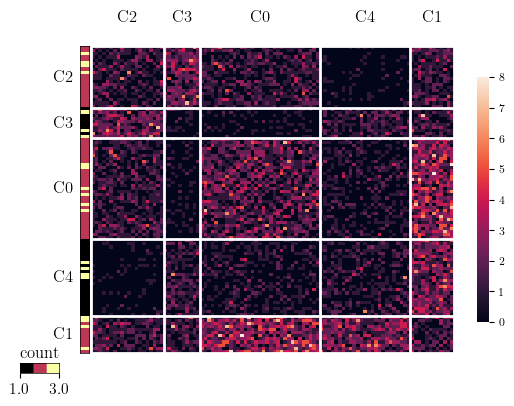

In [6]:
gen_model = BaseESBM(Y, 
              prior=prior, 
              clustering=clustering,
              likelihood=likelihood,
              covariates_1=[cov1, cov2, cov3], 
              bipartite=False)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(6,4), bipartite=False, triangular_mask=False)

In [7]:
rng = np.random.default_rng(2)

model = BaseESBM(Y, 
              prior=prior, 
              likelihood=likelihood,
              covariates_1=[cov1, cov2, cov3],
              epsilon=1e-10, 
              bipartite=False, 
              verbose=False, 
              clustering='Random',
              rng=rng)

# plot_heatmap(model, size=(6, 5), bipartite=False, triangular_mask=False)

out = model.fit(n_iters=100, verbose=True)

starting log likelihood -9745.216235764581
0 -8616.605799861687
time 0.03529070800868794
10 -7502.973099912947
time 0.30886558297788724
20 -7502.973099912947
time 0.31259162502828985
30 -7502.973099912947
time 0.3238622500211932
40 -7495.7233523725145
time 0.28904974996112287
50 -7495.7233523725145
time 0.27302966598654166
60 -7495.7233523725145
time 0.27326054201694205
70 -7495.7233523725145
time 0.27354200003901497
80 -7495.7233523725145
time 0.2711858329712413
90 -7495.7233523725145
time 0.27033845899859443
end llk:  -7495.7233523725145


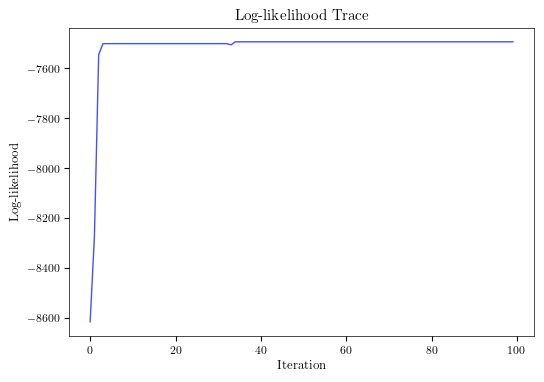

In [8]:
model.plot_trace(start=1)

We can now evaluate our fit of the model using
- a visual inspection of the estimated clustering structure (with comparison to the true one)
- the Variation of Information metric (the lower the better, zero means perfect recovery)

From the output of the cell below it is clear that the model recovers (almost) perfectly the true partition. We can also see from the heatmap that the clusters are indeed unifor in terms of covariates.

[0.]


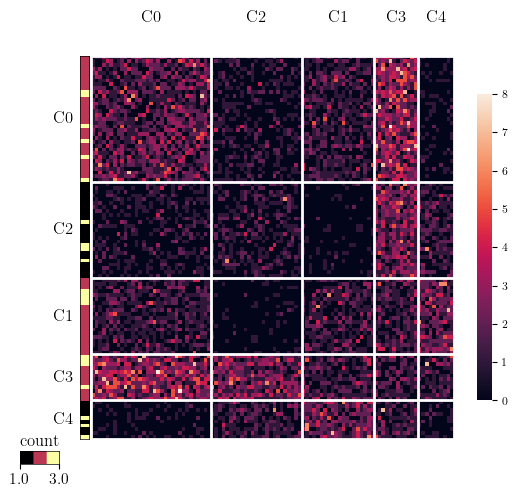

In [9]:
estimated = model.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
cl2 = estimated[2]
print(VI(clustering, cl1))

plot_heatmap(model, size=(6, 5), bipartite=True, triangular_mask=True)

### Too much information

One issue with these type of models is that the effect of covariates can overwhelm the signal from the network, especially for small networks. We illustrate here an example of this behaviour. 

We generate data for a network with 20 nodes and 3 different covariates all having the same value. This pushes the model to aggregate all clusters together.

In [41]:
n = 20

# manually define clustering structure
sizes = [n//5, n//10, n//3, n//4, n - (n//3)-(n//4)-(n//5)-(n//10)]
clustering = np.array(
    [0 for _ in range(sizes[0])] + 
    [1 for _ in range(sizes[1])] + 
    [2 for _ in range(sizes[2])] + 
    [3 for _ in range(sizes[3])] +
    [4 for _ in range(sizes[4])])

rng = np.random.default_rng(3)

Y = generate_poisson_data(1, 
                          1,
                          clustering, 
                          bipartite=False, 
                          rng=rng)

a = rng.permutation(n)
clustering = clustering[a]
Y = Y[a][:, a]

In [53]:
cov_values = np.zeros(n, dtype=int)
# add some noise
cov_values[rng.integers(0, len(cov_values), size=n//10)] = 1

cov1_2 = CountCovariate(name='count', cov_array=cov_values, a=2, b=5)
cov2_2 = CategoricalCovariate(name='cat', cov_array=cov_values, alpha_c=1)
cov3_2 = CategoricalCovariate(name='cat2', cov_array=cov_values, alpha_c=1)
cov4_2 = CategoricalCovariate(name='cat3', cov_array=cov_values, alpha_c=1)

-253.20666438010412


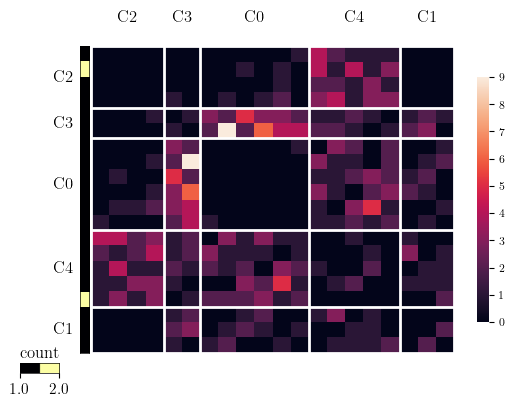

In [54]:
prior_shape = 1
prior_rate = 1

prior = DirichletProcess(concentration=2)
likelihood = PoissonGamma(shape=prior_shape, rate=prior_rate)

gen_model = BaseESBM(Y, 
              prior=prior, 
              clustering=clustering,
              likelihood=likelihood,
              covariates_1=[cov1_2, cov2_2, cov3_2, cov4_2], 
              bipartite=False)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(6,4), bipartite=False, triangular_mask=False)

In [58]:
rng = np.random.default_rng(4)

model = BaseESBM(Y, 
              prior=prior, 
              likelihood=likelihood,
              covariates_1=[cov1_2, cov2_2, cov3_2, cov4_2],
              epsilon=1e-10, 
              bipartite=False, 
              verbose=False, 
              clustering='Random',
              rng=rng)

# plot_heatmap(model, size=(6, 5), bipartite=False, triangular_mask=False)

out = model.fit(n_iters=100, verbose=True)

starting log likelihood -414.96099739157216
0 -401.9971357815346
time 0.012802875018678606
10 -269.4786285279686
time 0.07170283299637958
20 -269.5102303385593
time 0.05657479201909155
30 -257.7813276765545
time 0.057578332955017686
40 -269.4786285279686
time 0.05477270798292011
50 -265.3161052283952
time 0.053681750025134534
60 -264.0232070991244
time 0.052152458985801786
70 -264.93682874221577
time 0.05328079196624458
80 -301.739163238483
time 0.05455562501447275
90 -269.12749070266966
time 0.05534066603286192
end llk:  -270.351020549054


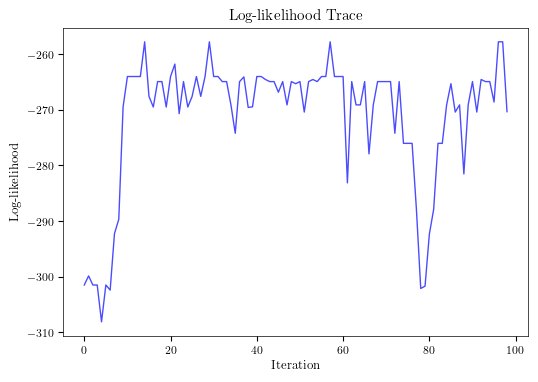

In [59]:
model.plot_trace(start=2)

From the output below we see that the model has aggregated the smaller clusters in a big one. 

[0.99205269]


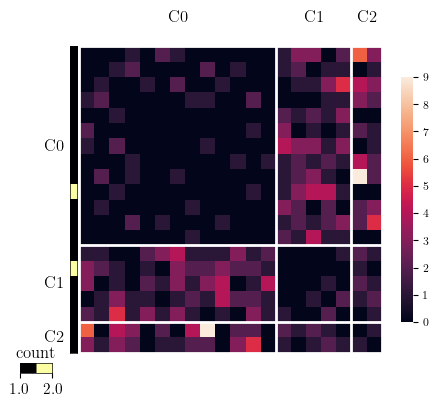

In [60]:
estimated = model.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
cl2 = estimated[2]
print(VI(clustering, cl1))

plot_heatmap(model, size=(5, 4), bipartite=True, triangular_mask=True)